<a href="https://colab.research.google.com/github/Rajsoni03/Covid-X-ray-Dataset/blob/main/Mini_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sleep Runtime for A Day

from time import sleep

for i in range(1440):
  print(i, 'min')


# Importing Libraries

In [363]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Input, Dense, MaxPooling2D, Conv2D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import shutil
import time
import cv2
import os

from IPython.display import clear_output

print('Library Importing Complete')

Library Importing Complete


# Importing Data

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copy data from Drive to Local Storage
shutil.copytree('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/mini_data', '/content/data')

'/content/data'

In [5]:
print('Covid', len(os.listdir('/content/data/train/covid'))+len(os.listdir('/content/data/test/covid'))+len(os.listdir('/content/data/val/covid')))
print('Normal', len(os.listdir('/content/data/train/normal'))+len(os.listdir('/content/data/test/normal'))+len(os.listdir('/content/data/val/normal')))
print('Pneumonoia', len(os.listdir('/content/data/train/pneumonia'))+len(os.listdir('/content/data/test/pneumonia'))+len(os.listdir('/content/data/val/pneumonia')))

Covid 312
Normal 1471
Pneumonoia 1347


In [211]:
# initialize the training and Val data augmentation object
tarin_data_gen = ImageDataGenerator(rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    rescale=1./255)

train_data_gen = tarin_data_gen.flow_from_directory('/content/data/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = val_data_gen.flow_from_directory('/content/data/val',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 2501 images belonging to 3 classes.
Found 317 images belonging to 3 classes.


#Creating Model

In [ ]:
# input_X = Input(shape=(224, 224, 3))

# X = Conv2D(16, (3, 3), activation='relu')(input_X)
# X = MaxPooling2D((2, 2))(X)

# X = Conv2D(32, (3, 3), activation='relu')(X)
# X = MaxPooling2D((2, 2))(X)

# X = Conv2D(64, (3, 3), activation='relu')(X)
# X = MaxPooling2D((2, 2))(X)

# X = AveragePooling2D((4,4))(X)
# X = Flatten()(X)
# X = Dense(128, activation='relu')(X)
# X = Dense(128, activation='relu')(X)
# X = Dense(3, activation='softmax')(X)

# model = Model(inputs=input_X, outputs=X)

# model.summary()

In [244]:
input_X = Input(shape=(224, 224, 3))

X = Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu')(input_X)
X = MaxPooling2D((2, 2), padding='same')(X)

X = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(X)
X = MaxPooling2D((2, 2), padding='same')(X)

X = Conv2D(96, (3, 3), padding='same', strides=(1, 1), activation='relu')(X)
X = MaxPooling2D((2, 2), padding='same')(X)

C1 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P1 = MaxPooling2D((2,2), padding='same')(C1)
C2 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P2 = MaxPooling2D((2,2), padding='same')(C2)
C3 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P3 = MaxPooling2D((2,2), padding='same')(C3)
X = Concatenate(axis=-1)([P1, P2, P3])
X = BatchNormalization()(X)

X = AveragePooling2D((7,7))(X)
X = Dropout(.8)(X)
X = Flatten()(X)
X = Dense(256, activation='relu')(X)
X = Dense(128, activation='relu')(X)
X = Dense(3, activation='softmax')(X)

model = Model(inputs=input_X, outputs=X)

model.summary()

Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_428 (Conv2D)             (None, 224, 224, 32) 896         input_42[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_264 (MaxPooling2D (None, 112, 112, 32) 0           conv2d_428[0][0]                 
__________________________________________________________________________________________________
conv2d_429 (Conv2D)             (None, 112, 112, 64) 18496       max_pooling2d_264[0][0]          
______________________________________________________________________________________

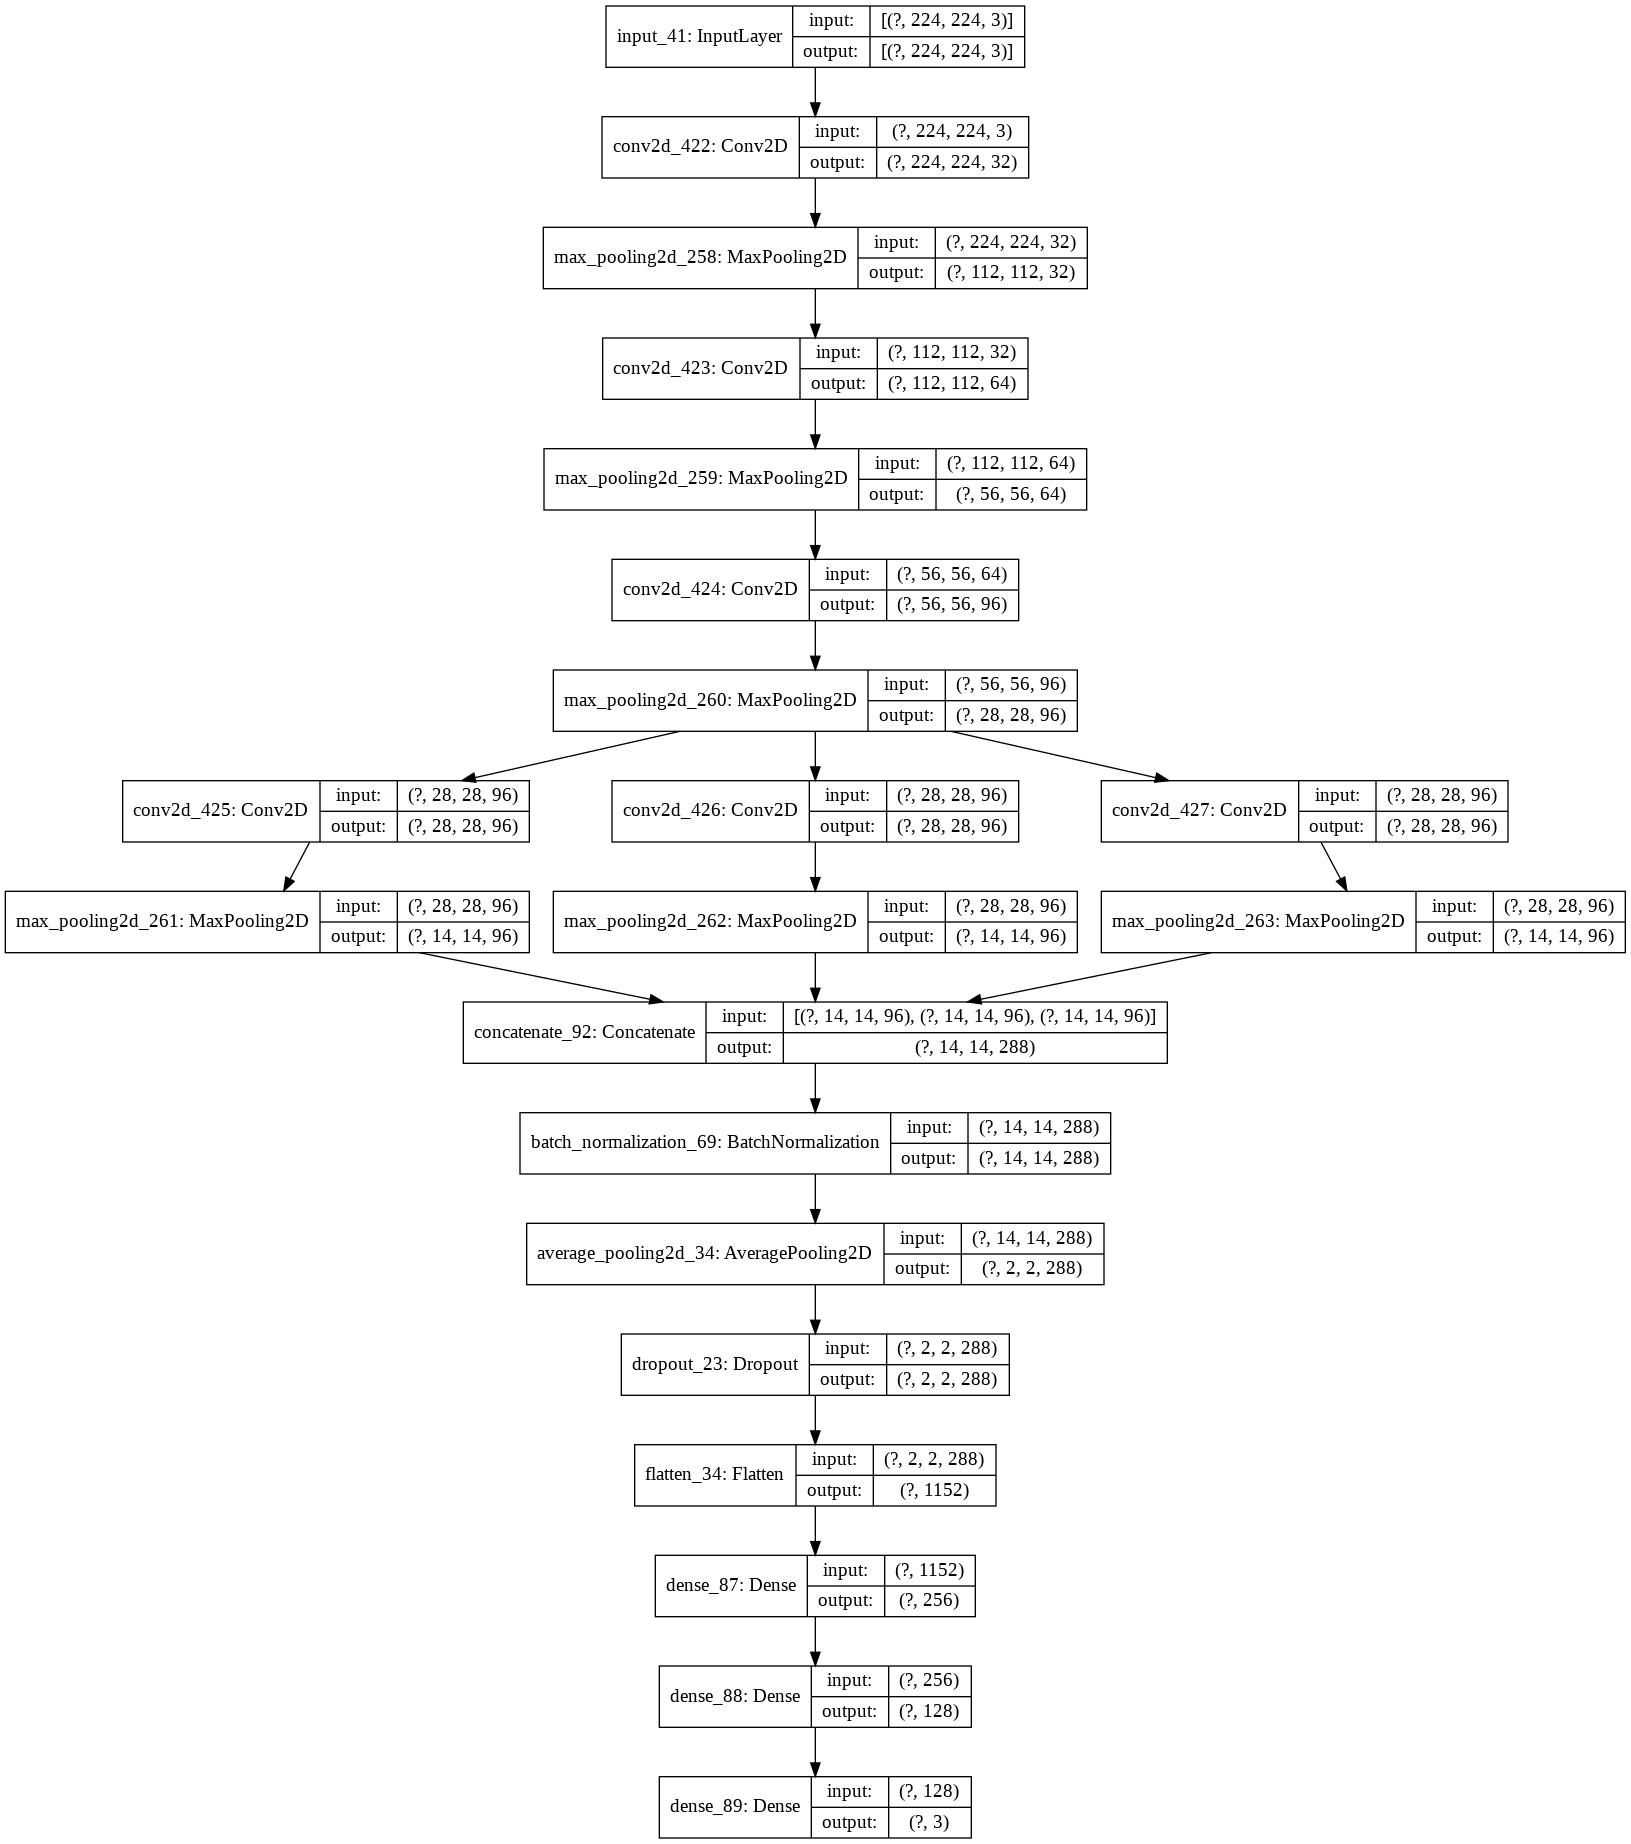

In [220]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Setup Hyperparameters

In [274]:
Epochs = 20
BS = 32
LR = 1e-5
# decay = LR / Epochs

In [250]:
1e-5 * 10**(Epochs/4)

1.0

In [251]:
lr_schedule = LearningRateScheduler(lambda epoch:1e-5 * 10**(epoch/4))
opt = Adam(lr=LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [252]:
# train the model
Mini_H = model.fit_generator(train_data_gen, 
                             validation_data=val_data_gen,
                             epochs=Epochs,
                             callbacks=[lr_schedule]
                             )

Epoch 1/20
79/79 [==============================] - 32s 400ms/step - loss: 1.0938 - accuracy: 0.3994 - val_loss: 1.0808 - val_accuracy: 0.4700
Epoch 2/20
79/79 [==============================] - 31s 397ms/step - loss: 0.9623 - accuracy: 0.5050 - val_loss: 1.0605 - val_accuracy: 0.4700
Epoch 3/20
79/79 [==============================] - 31s 398ms/step - loss: 0.8642 - accuracy: 0.5942 - val_loss: 1.0080 - val_accuracy: 0.5615
Epoch 4/20
79/79 [==============================] - 31s 398ms/step - loss: 0.7480 - accuracy: 0.6697 - val_loss: 0.9092 - val_accuracy: 0.7224
Epoch 5/20
79/79 [==============================] - 32s 401ms/step - loss: 0.6081 - accuracy: 0.7561 - val_loss: 0.7815 - val_accuracy: 0.7729
Epoch 6/20
79/79 [==============================] - 31s 396ms/step - loss: 0.5650 - accuracy: 0.7961 - val_loss: 0.7280 - val_accuracy: 0.6215
Epoch 7/20
79/79 [==============================] - 31s 398ms/step - loss: 0.5303 - accuracy: 0.8001 - val_loss: 0.9823 - val_accuracy: 0.4890

In [257]:
# Save the model
model.save('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_lr.h5')
pd.DataFrame(Mini_H.history).to_csv('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_lr.csv')

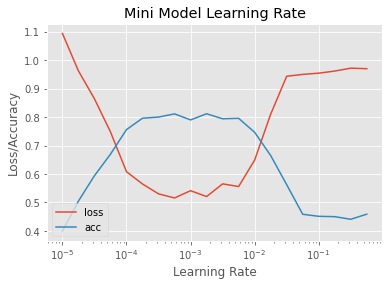

In [268]:
plt.style.use("ggplot")
plt.figure()
plt.semilogx(Mini_H.history["lr"], Mini_H.history["loss"], label="loss")
plt.semilogx(Mini_H.history["lr"], Mini_H.history["accuracy"], label="acc")
plt.title('Mini Model Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss/Accuracy')
plt.legend(loc="lower left")
plt.show()

#Train Model

In [273]:
input_X = Input(shape=(224, 224, 3))

X = Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='relu')(input_X)
X = MaxPooling2D((2, 2), padding='same')(X)

X = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(X)
X = MaxPooling2D((2, 2), padding='same')(X)

X = Conv2D(96, (3, 3), padding='same', strides=(1, 1), activation='relu')(X)
X = MaxPooling2D((2, 2), padding='same')(X)

C1 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P1 = MaxPooling2D((2,2), padding='same')(C1)
C2 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P2 = MaxPooling2D((2,2), padding='same')(C2)
C3 = Conv2D(96, (3, 3),  padding='same', strides=(1, 1), activation='relu')(X)
P3 = MaxPooling2D((2,2), padding='same')(C3)
X = Concatenate(axis=-1)([P1, P2, P3])
X = BatchNormalization()(X)

X = AveragePooling2D((7,7))(X)
X = Dropout(.8)(X)
X = Flatten()(X)
X = Dense(256, activation='relu')(X)
X = Dense(128, activation='relu')(X)
X = Dense(3, activation='softmax')(X)

model = Model(inputs=input_X, outputs=X)


In [276]:
Epochs = 50
BS = 32
LR = 1e-3

In [277]:
opt = Adam(lr=LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [278]:
# train the model
Mini_H_train = model.fit_generator(train_data_gen, 
                             validation_data=val_data_gen,
                             epochs=Epochs,
                             )

Epoch 1/50
79/79 [==============================] - 32s 401ms/step - loss: 0.7646 - accuracy: 0.6517 - val_loss: 0.9335 - val_accuracy: 0.4700
Epoch 2/50
79/79 [==============================] - 31s 398ms/step - loss: 0.5634 - accuracy: 0.7829 - val_loss: 0.9059 - val_accuracy: 0.4732
Epoch 3/50
79/79 [==============================] - 31s 397ms/step - loss: 0.4983 - accuracy: 0.8181 - val_loss: 0.8572 - val_accuracy: 0.5016
Epoch 4/50
79/79 [==============================] - 31s 398ms/step - loss: 0.4611 - accuracy: 0.8393 - val_loss: 0.7650 - val_accuracy: 0.8328
Epoch 5/50
79/79 [==============================] - 31s 397ms/step - loss: 0.4501 - accuracy: 0.8425 - val_loss: 1.1793 - val_accuracy: 0.4385
Epoch 6/50
79/79 [==============================] - 31s 398ms/step - loss: 0.4352 - accuracy: 0.8421 - val_loss: 0.6871 - val_accuracy: 0.6120
Epoch 7/50
79/79 [==============================] - 32s 400ms/step - loss: 0.3994 - accuracy: 0.8469 - val_loss: 0.3871 - val_accuracy: 0.8644

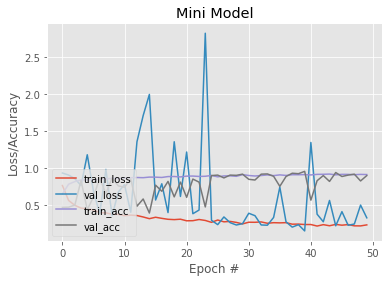

In [283]:
# plot the training loss and accuracy
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), Mini_H_train.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Mini_H_train.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), Mini_H_train.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Mini_H_train.history["val_accuracy"], label="val_acc")
# plt.axis([15, 20, 0, 1])
plt.title('Mini Model')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [305]:
# Save the model
model.save('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_train.h5')
pd.DataFrame(Mini_H_train.history).to_csv('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_train.csv')

# Fine Tuning Model

In [294]:
my_model = load_model('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_train.h5')

In [295]:
for i in my_model.layers[:14]:
  i.trainable=False

for i in my_model.layers:
  print(i.trainable, i)

False <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2004332b00>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20043325f8>
False <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f20043321d0>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2004332f60>
False <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2004332ef0>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20043329e8>
False <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f20043323c8>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f21c6163d68>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f222ea54860>
False <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2004332d30>
False <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2004332160>
False <tensorflow.python.keras.layers.pooling.MaxPooling2D obje

In [296]:
# initialize the training and Val data augmentation object
tarin_data_gen_fine = ImageDataGenerator(rescale=1./255)

train_data_gen_fine = tarin_data_gen_fine.flow_from_directory('/content/data/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_data_gen_fine = ImageDataGenerator(rescale=1./255)
val_data_gen_fine = val_data_gen_fine.flow_from_directory('/content/data/val',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

test_data_gen_fine = ImageDataGenerator(rescale=1./255)
test_data_gen_fine = test_data_gen_fine.flow_from_directory('/content/data/test',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 2501 images belonging to 3 classes.
Found 317 images belonging to 3 classes.
Found 312 images belonging to 3 classes.


In [297]:
Epochs = 50
BS = 32
LR = 1e-3

opt = Adam(lr=LR)
my_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [298]:
# train the model
Mini_H_fine_tune = my_model.fit_generator(train_data_gen_fine, 
                             validation_data=val_data_gen_fine,
                             epochs=Epochs,
                             )

Epoch 1/50
79/79 [==============================] - 7s 90ms/step - loss: 0.1765 - accuracy: 0.9368 - val_loss: 0.1661 - val_accuracy: 0.9369
Epoch 2/50
79/79 [==============================] - 7s 86ms/step - loss: 0.1687 - accuracy: 0.9388 - val_loss: 0.1316 - val_accuracy: 0.9558
Epoch 3/50
79/79 [==============================] - 7s 86ms/step - loss: 0.1751 - accuracy: 0.9400 - val_loss: 0.1492 - val_accuracy: 0.9432
Epoch 4/50
79/79 [==============================] - 7s 85ms/step - loss: 0.1568 - accuracy: 0.9424 - val_loss: 0.1286 - val_accuracy: 0.9558
Epoch 5/50
79/79 [==============================] - 7s 88ms/step - loss: 0.1510 - accuracy: 0.9460 - val_loss: 0.1124 - val_accuracy: 0.9590
Epoch 6/50
79/79 [==============================] - 7s 87ms/step - loss: 0.1380 - accuracy: 0.9520 - val_loss: 0.1191 - val_accuracy: 0.9495
Epoch 7/50
79/79 [==============================] - 7s 86ms/step - loss: 0.1346 - accuracy: 0.9508 - val_loss: 0.1279 - val_accuracy: 0.9527
Epoch 8/50
79

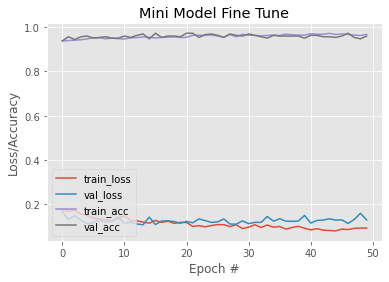

In [301]:
# plot the training loss and accuracy
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), Mini_H_fine_tune.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Mini_H_fine_tune.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), Mini_H_fine_tune.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Mini_H_fine_tune.history["val_accuracy"], label="val_acc")
# plt.axis([15, 20, 0, 1])
plt.title('Mini Model Fine Tune')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [306]:
# Save the model
my_model.save('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_fine.h5')
pd.DataFrame(Mini_H_fine_tune.history).to_csv('/content/drive/MyDrive/AI Colab/Final Covid Diagnosis/models/Mini_model_v2_fine.csv')

# Eveluate Model

In [349]:
data_path = '/content/data/test'

print("loading images", end='')
imagePaths = list(paths.list_images(data_path))
print(f' : {len(imagePaths)} images in data directory')
data, labels = [], []

_C, _N, _P = 1,1,1


# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if label == 'covid' and _C <= 700:        # importing 700 Covid CRX images
      data.append(image)
      labels.append(label)
      _C += 1
    if label == 'normal' and _N <= 2150:      # importing 2150 Normal CRX images
      data.append(image)
      labels.append(label)
      _N += 1
    if label == 'pneumonia' and _P <= 2150:   # importing 2150 Pneumonia CRX images
      data.append(image)
      labels.append(label)
      _P += 1


data = np.array(data) / 255.0
labels = np.array(labels)

print('encoding the labels')
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels) # for 2 classes

print(f"Total {len(data)} images are loaded")
print(f"Data Shape : {data.shape} \nLebals Shape : {labels.shape}")

loading images : 312 images in data directory
encoding the labels
Total 312 images are loaded
Data Shape : (312, 224, 224, 3) 
Lebals Shape : (312, 3)


In [355]:
# make predictions on the testing set
probabilities = my_model.predict(data)

y_true = labels.argmax(axis=1)
y_pred = np.argmax(probabilities, axis=1)

In [356]:
cf = classification_report(y_true, y_pred, target_names=lb.classes_) # classification report
print(cf)

              precision    recall  f1-score   support

       covid       0.94      0.94      0.94        31
      normal       0.92      0.98      0.95       147
   pneumonia       0.97      0.90      0.93       134

    accuracy                           0.94       312
   macro avg       0.94      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312



[[ 29   1   1]
 [  0 144   3]
 [  2  11 121]]


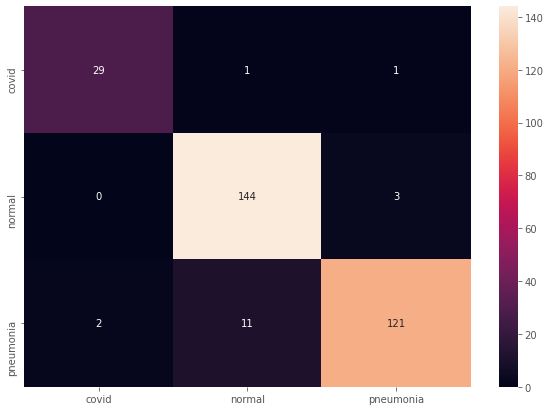

In [367]:
cm = confusion_matrix(y_true, y_pred) # confusion matrix

df_cm = pd.DataFrame(cm, index=['covid', 'normal', 'pneumonia'], columns = ['covid', 'normal', 'pneumonia'])
plt.style.use("ggplot")
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [310]:
my_model.evaluate(train_data_gen_fine)

79/79 [==============================] - 6s 76ms/step - loss: 0.0319 - accuracy: 0.9904


[0.03192654997110367, 0.9904038310050964]

In [311]:
my_model.evaluate(val_data_gen_fine)

10/10 [==============================] - 1s 67ms/step - loss: 0.1301 - accuracy: 0.9590


[0.13005660474300385, 0.9589905142784119]

In [312]:
my_model.evaluate(test_data_gen_fine)

10/10 [==============================] - 1s 67ms/step - loss: 0.1380 - accuracy: 0.9423


[0.13800430297851562, 0.942307710647583]